
# Implementation of coordinate descent optimization algorithm

In this notebook, the SVM coordinate descent optimization algorithm implementation is tested on following datasets:

- artificially generated data (artificial sparse data)
- smoking data
- banknote authentication data
- wisconsin breast cancer data
- haberman data

# Solving for artificial Data

In [1]:
import pandas as pd
import numpy as np
import bz2
from time import time

import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

In [284]:
# New data test
f_d = 50
d_d = 5000
X = np.ones((d_d,f_d))
Y = np.zeros(d_d)
for i in range(d_d):
  if i < d_d/2:
    X[i,:f_d-1] = np.random.normal(1, 1, f_d-1)*np.random.choice([0, 1], size=f_d-1, p=[.9, .1])
    X[i, f_d-1] = 1
    
    Y[i] = 1
  else:
    X[i,:f_d-1] = np.random.normal(-1, 1, f_d-1)*np.random.choice([0, 1], size=f_d-1, p=[.9, .1])
    X[i, f_d-1] = 1
    Y[i] = -1


In [23]:
# bias term
X[:, f_d-1]


array([1., 1., 1., ..., 1., 1., 1.])

In [283]:
# # maybe not ? ;) - not run for now
# for i in range(f_d):
#   mean = X[:,i].mean()
#   std = X[:,i].std()
#   if std == 0: #If column of zeros
#     std = 1
#     print("Std is Zero")
#   X[:,i] = (X[:,i] - mean)/std

Std is Zero


In [285]:
# train test split 80/20%

X_train, X_test,Y_train, Y_test = train_test_split(X,Y, random_state=44, train_size= 0.8)

In [286]:
# svc from library
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = "l1", loss = "squared_hinge", max_iter = 100, C = 5, dual = False) # last 2 params - same as in our algorithm

t0 = time()
svc.fit(X_train,Y_train)
t1 = time()

print("Time of LinearSVC algorithm per iteration: " + str((t1-t0)/100  ) + " seconds")

svc_acc = svc.score(X_test,Y_test)

print("Acc: " + str(svc_acc))



Time of LinearSVC algorithm per iteration: 0.00010751008987426758 seconds
Acc: 0.971


In [287]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X_train.shape[1]
n_of_observations = Y_train.shape[0]


# saved variables

# inner
dprim0s = []
dbis0s = []
ds = []
weights_sums = []
accs_inner = []
almighty_all_weights = []

for i in range(n_of_features):
    almighty_all_weights.append(list())

#outer
dprim0s2 = []
dbis0s2 = []
ds2 = []
first_weights = []
outer_iteration_times = []
accs = []



# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
weights = np.ones((n_of_features)) * 100

# hyperparameters
beta = 0.5
sigma = 0.01
C = 5

# outer iterations:
for k in range(100):
    # inner iterations shuld be as many as the number of features
    
    t0 = time()
    
    
    first_weights.append(weights[0])
    for i in range(n_of_features):
        almighty_all_weights[i].append(weights[i])
        
#         if(i%100==0):
#           print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X_train[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y_train[shuffle] #np.array(Y.iloc[shuffle])
        X_ = X_train[shuffle,:]
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        #----- calculating D'  for z = 0 , in the article: equation (9)
        for j in range(n_of_observations): 
            #----- b_j defined in thr article, part of D' calculations
            b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0: #----- indicator defined in the article
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)
        D_prim_0 += np.sign(weights[i]) # L1 regularization

        #D_prim_0 += weights[0,i]
        #D_prim_0 += weights[i]


        #----- calculating D''  for z = 0 , in the article: equation (10)
#         D_bis_0 = 1 + 2*C*sum_of_squares_of_column # L2 regularization
        D_bis_0 = 2*C*sum_of_squares_of_column # L1 reglarization
        #-----  equation (13) in the article
        d = -D_prim_0/D_bis_0 
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            

        ds.append(d)
        dprim0s.append(D_prim_0)
        dbis0s.append(D_bis_0)
        weights_sums.append(weights.sum())
        
        
        acc = 0.0
        for l in range(Y_test.shape[0]):
          if np.dot(weights,X_test[l,:])*Y_test[l] < 0:
            acc += 1
        accs_inner.append(acc/Y_test.shape[0])
        
        
        
        
        
        # update weights
        weights[i] -= lambd*d
        
    ds2.append(d)
    dprim0s2.append(D_prim_0)
    dbis0s2.append(D_bis_0)
    outer_iteration_times.append(time() - t0)
        
        
    
    if k % 10 == 0:
#     if True:
        print("outer iteration - ", k)
        acc = 0.0
        for i in range(Y_test.shape[0]):
          if np.dot(weights,X_test[i,:])*Y_test[i] < 0:
            acc += 1
        print("Accuracy ",acc/Y_test.shape[0])
        print("Weights sum: ",weights.sum())
        print("\n")
        accs.append(acc/Y_test.shape[0])


outer iteration -  0
Accuracy  0.828
Weights sum:  -3171.7623719351013


outer iteration -  10
Accuracy  0.941
Weights sum:  -3959.1380269003594


outer iteration -  20
Accuracy  0.948
Weights sum:  -3943.040105975417


outer iteration -  30
Accuracy  0.957
Weights sum:  -3896.7724332548282


outer iteration -  40
Accuracy  0.96
Weights sum:  -3835.843240080992


outer iteration -  50
Accuracy  0.959
Weights sum:  -3766.469533019242


outer iteration -  60
Accuracy  0.96
Weights sum:  -3703.084440538113


outer iteration -  70
Accuracy  0.962
Weights sum:  -3637.624883366669


outer iteration -  80
Accuracy  0.963
Weights sum:  -3572.945428924956


outer iteration -  90
Accuracy  0.964
Weights sum:  -3508.605556949892




In [288]:
print("MAX ACCURACY ON TEST DATASET: " + str(np.max(accs_inner)))


MAX ACCURACY ON TEST DATASET: 0.965


In [289]:
print("AVERAGE TIME PER OUTER ITERATION: " + str(round(np.mean(outer_iteration_times), 5)) + " seconds")


AVERAGE TIME PER OUTER ITERATION: 1.76045 seconds


Text(0, 0.5, "d's value")

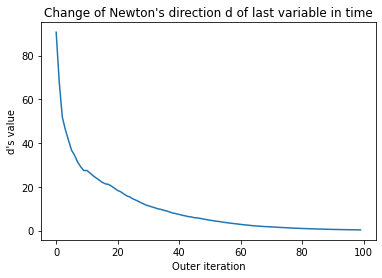

In [290]:
ax = sns.lineplot(x = inn_it[0:100], y = ds2[0:100])
ax.set_title("Change of Newton's direction d of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("d's value")

Text(0, 0.5, "D''(0) value")

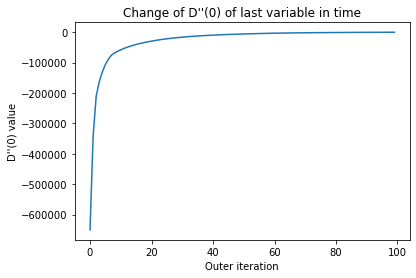

In [291]:
ax = sns.lineplot(x = inn_it[0:100], y = dprim0s2[0:100])
ax.set_title("Change of D''(0) of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("D''(0) value")

Text(0, 0.5, "Weights' sum")

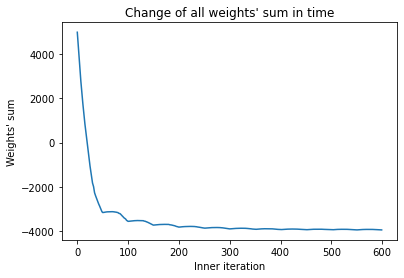

In [295]:
ax = sns.lineplot(x = inn_it[0:600], y = weights_sums[0:600])
ax.set_title("Change of all weights' sum in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Weights' sum")

LinearSVC Accuracy ( for comparison): 0.971


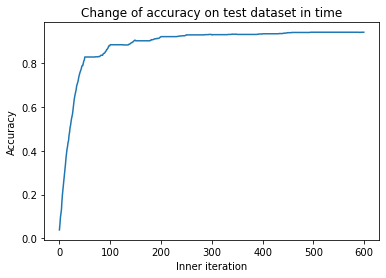

In [296]:
ax = sns.lineplot(x = inn_it[0:600], y = accs_inner[0:600])
ax.set_title("Change of accuracy on test dataset in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Accuracy")

print("LinearSVC Accuracy ( for comparison): " + str(svc_acc))

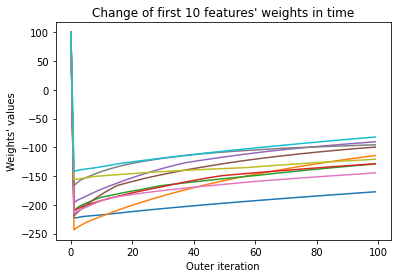

In [302]:
ax = sns.lineplot(x = inn_it[0:100], y = first_weights[0:100])
ax.set_title("Change of first 10 features' weights in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("Weights' values")


for i in range(1, 10):
    sns.lineplot(x = inn_it[0:100], y = almighty_all_weights[i][0:100])

# 0. Smoking data

In [70]:
!ls data

real-sim.bz2
real-sim-col.csv
smoking.csv
X.csv
Y.csv


In [247]:
 # https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking

data = pd.read_csv('data/smoking.csv')

In [248]:
Y = data['smoking']
Y[Y == 0.0] = -1

C:\Users\Patryk\AppData\Local\Temp/ipykernel_14592/223503117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y == 0.0] = -1


In [249]:
data = data.iloc[0:-2,0:-1]

In [275]:
np.unique(data['oral'])

array(['Y'], dtype=object)

In [250]:
data.loc[data['gender'] == 'M', 'gender'] = 1
data.loc[data['gender'] == 'F', 'gender'] = 0

data.loc[data['tartar'] == 'Y', 'tartar'] = 1
data.loc[data['tartar'] == 'N', 'tartar'] = 0

In [251]:
data = data.drop('oral', axis=1)

In [278]:
data

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar
0,0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,...,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1
1,1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,...,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1
2,2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,...,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0
3,3,1,40,165,70,88.0,1.5,1.5,1.0,1.0,...,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,1
4,4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,...,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55685,55671,1,40,170,80,90.5,1.2,1.5,1.0,1.0,...,57.0,135.0,14.8,1.0,0.9,16.0,28.0,68.0,0,1
55686,55673,0,60,150,50,75.0,1.0,1.2,1.0,1.0,...,52.0,116.0,12.6,1.0,0.8,26.0,21.0,14.0,0,1
55687,55676,0,40,170,65,75.0,0.9,0.9,1.0,1.0,...,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,1
55688,55681,0,45,160,50,70.0,1.2,1.2,1.0,1.0,...,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,1


In [260]:
Y = Y[0:-2]

In [236]:
Y

0       -1
1       -1
2        1
3       -1
4       -1
        ..
55685   -1
55686   -1
55687   -1
55688   -1
55689   -1
Name: smoking, Length: 55690, dtype: int64

In [99]:
data.iloc[:,1:25]

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0
3,1,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,1
4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55685,1,40,170,80,90.5,1.2,1.5,1.0,1.0,130.0,...,57.0,135.0,14.8,1.0,0.9,16.0,28.0,68.0,0,1
55686,0,60,150,50,75.0,1.0,1.2,1.0,1.0,102.0,...,52.0,116.0,12.6,1.0,0.8,26.0,21.0,14.0,0,1
55687,0,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,...,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,1
55688,0,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,...,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,1


In [252]:
X = np.asarray(data.iloc[:,1:25])

In [238]:
X.shape

(55690, 24)

In [282]:
Y

0       -1
1       -1
2        1
3       -1
4       -1
        ..
55685   -1
55686   -1
55687   -1
55688   -1
55689   -1
Name: smoking, Length: 55690, dtype: int64

In [253]:
for i in range(24):
  meann = X[:,i].mean()
  std = X[:,i].std()
  if std == 0: #If column of zeros
    std = 1
    print("Std is Zero")
  X[:,i] = (X[:,i] - meann)/std

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [254]:
X = np.concatenate([X, np.ones(shape = (X.shape[0], 1))], axis=1)

In [258]:
X.shape

(55690, 25)

In [261]:
Y.shape

(55690,)

In [256]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
# Y = Y[0:-2]

In [262]:
# train test split 80/20%


X_train, X_test,Y_train, Y_test = train_test_split(X,Y, random_state=44, train_size= 0.8)




In [266]:
# svc from library
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = "l1", loss = "squared_hinge", max_iter = 10, C = 5, dual = False) # last 2 params - same as in our algorithm

t0 = time()
svc.fit(X_train,Y_train)
t1 = time()

print("Time of LinearSVC algorithm per iteration: " + str((t1-t0)/100  ) + " seconds")

svc_acc = svc.score(X_test,Y_test)

print("Acc: " + str(svc_acc))



Time of LinearSVC algorithm per iteration: 0.0027649474143981935 seconds
Acc: 0.7438498832824565


C:\Users\Patryk\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [265]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X_train.shape[1]
n_of_observations = Y_train.shape[0]


# saved variables

# inner
dprim0s = []
dbis0s = []
ds = []
weights_sums = []
accs_inner = []
almighty_all_weights = []

for i in range(n_of_features):
    almighty_all_weights.append(list())

#outer
dprim0s2 = []
dbis0s2 = []
ds2 = []
first_weights = []
outer_iteration_times = []
accs = []



# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
weights = np.ones((n_of_features)) * 100

# hyperparameters
beta = 0.5
sigma = 0.01
C = 5

# outer iterations:
for k in range(100):
    # inner iterations shuld be as many as the number of features
    
    t0 = time()
    
    
    first_weights.append(weights[0])
    for i in range(n_of_features):
        almighty_all_weights[i].append(weights[i])
        
#         if(i%100==0):
#           print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X_train[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y_train[shuffle] #np.array(Y.iloc[shuffle])
        X_ = X_train[shuffle,:]
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        #----- calculating D'  for z = 0 , in the article: equation (9)
        for j in range(n_of_observations): 
            #----- b_j defined in thr article, part of D' calculations
            b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0: #----- indicator defined in the article
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)

        #D_prim_0 += weights[0,i]
        #D_prim_0 += weights[i]


        #----- calculating D''  for z = 0 , in the article: equation (10)
        D_bis_0 = 1 + 2*C*sum_of_squares_of_column

        #-----  equation (13) in the article
        d = -D_prim_0/D_bis_0 
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            

        ds.append(d)
        dprim0s.append(D_prim_0)
        dbis0s.append(D_bis_0)
        weights_sums.append(weights.sum())
        
        
        acc = 0.0
        for l in range(Y_test.shape[0]):
          if np.dot(weights,X_test[l,:])*Y_test[l] < 0:
            acc += 1
        accs_inner.append(acc/Y_test.shape[0])
        
        
        
        
        
        # update weights
        weights[i] -= lambd*d
        
    ds2.append(d)
    dprim0s2.append(D_prim_0)
    dbis0s2.append(D_bis_0)
    outer_iteration_times.append(time() - t0)
        
        
    
    if k % 10 == 0:
#     if True:
        print("outer iteration - ", k)
        acc = 0.0
        for i in range(Y_test.shape[0]):
          if np.dot(weights,X_test[i,:])*Y_test[i] < 0:
            acc += 1
        print("Accuracy ",acc/Y_test.shape[0])
        print("Weights sum: ",weights.sum())
        print("\n")
        accs.append(acc/Y_test.shape[0])


outer iteration -  0
Accuracy  0.6722930508170228
Weights sum:  359.8714603158697


outer iteration -  10
Accuracy  0.6736397917040762
Weights sum:  -20.615663733856223




KeyboardInterrupt: 

In [267]:
print("MAX ACCURACY ON TEST DATASET: " + str(np.max(accs_inner)))


MAX ACCURACY ON TEST DATASET: 0.6852217633327348


In [268]:
print("AVERAGE TIME PER OUTER ITERATION: " + str(round(np.mean(outer_iteration_times), 5)) + " seconds")


AVERAGE TIME PER OUTER ITERATION: 33.30944 seconds


Text(0, 0.5, "d's value")

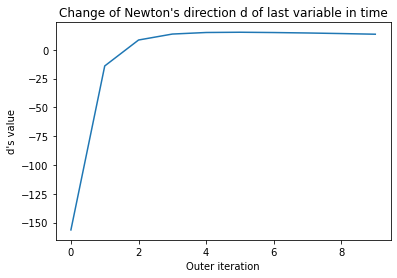

In [271]:
ax = sns.lineplot(x = inn_it[0:10], y = ds2[0:10])
ax.set_title("Change of Newton's direction d of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("d's value")

Text(0, 0.5, "D''(0) value")

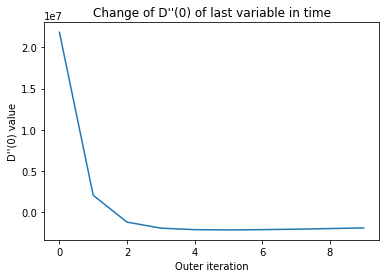

In [275]:
ax = sns.lineplot(x = inn_it[0:10], y = dprim0s2[0:10])
ax.set_title("Change of D''(0) of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("D''(0) value")

Text(0, 0.5, "Weights' sum")

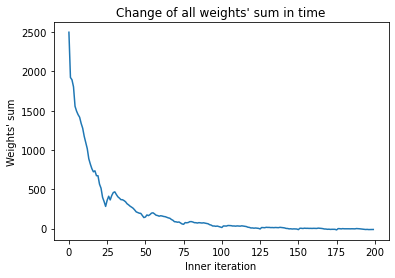

In [279]:
ax = sns.lineplot(x = inn_it[0:200], y = weights_sums[0:200])
ax.set_title("Change of all weights' sum in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Weights' sum")

LinearSVC Accuracy ( for comparison): 0.7438498832824565


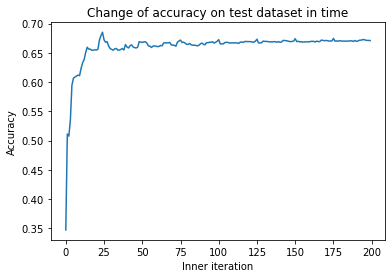

In [280]:
ax = sns.lineplot(x = inn_it[0:200], y = accs_inner[0:200])
ax.set_title("Change of accuracy on test dataset in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Accuracy")

print("LinearSVC Accuracy ( for comparison): " + str(svc_acc))





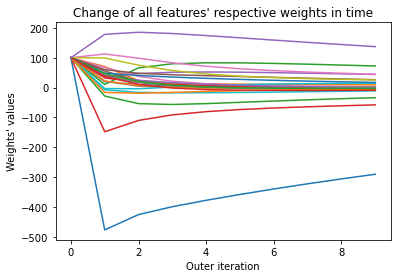

In [281]:
ax = sns.lineplot(x = inn_it[0:10], y = first_weights[0:10])
ax.set_title("Change of all features' respective weights in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("Weights' values")


for i in range(1, len(almighty_all_weights)):
    sns.lineplot(x = inn_it[0:10], y = almighty_all_weights[i][0:10])

# 1. Banknote authentication data

In [163]:
!ls data

data_banknote_authentication.txt
real-sim.bz2
real-sim-col.csv
smoking.csv
X.csv
Y.csv


In [193]:
# https://archive.ics.uci.edu/ml/datasets/banknote+authentication

data = pd.read_csv("data/data_banknote_authentication.txt", header = None)

In [194]:
X = data.iloc[:,0:4]
Y = data.iloc[:,4]

label_mapping = {0: -1,
                1: 1}

Y = Y.map(label_mapping)

X = np.array(X)
Y = np.array(Y)

# free term
X = np.concatenate([X, np.ones(shape = (X.shape[0], 1))], axis=1)

In [196]:
# train test split 80/20%


X_train, X_test,Y_train, Y_test = train_test_split(X,Y, random_state=44, train_size= 0.8)




In [219]:
# svc from library
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = "l1", loss = "squared_hinge", max_iter = 100, C = 5, dual = False) # last 2 params - same as in our algorithm

t0 = time()
svc.fit(X_train,Y_train)
t1 = time()

print("Time of LinearSVC algorithm per iteration: " + str((t1-t0)/100  ) + " seconds")

svc_acc = svc.score(X_test,Y_test)

print("Acc: " + str(svc_acc))



Time of LinearSVC algorithm per iteration: 9.488821029663086e-05 seconds
Acc: 0.9890909090909091


C:\Users\Patryk\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [220]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X_train.shape[1]
n_of_observations = Y_train.shape[0]


# saved variables

# inner
dprim0s = []
dbis0s = []
ds = []
weights_sums = []
accs_inner = []
almighty_all_weights = []

for i in range(n_of_features):
    almighty_all_weights.append(list())

#outer
dprim0s2 = []
dbis0s2 = []
ds2 = []
first_weights = []
outer_iteration_times = []
accs = []



# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
weights = np.ones((n_of_features)) * 100

# hyperparameters
beta = 0.5
sigma = 0.01
C = 5

# outer iterations:
for k in range(100):
    # inner iterations shuld be as many as the number of features
    
    t0 = time()
    
    
    first_weights.append(weights[0])
    for i in range(n_of_features):
        almighty_all_weights[i].append(weights[i])
        
#         if(i%100==0):
#           print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X_train[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y_train[shuffle] #np.array(Y.iloc[shuffle])
        X_ = X_train[shuffle,:]
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        #----- calculating D'  for z = 0 , in the article: equation (9)
        for j in range(n_of_observations): 
            #----- b_j defined in thr article, part of D' calculations
            b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0: #----- indicator defined in the article
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)

        #D_prim_0 += weights[0,i]
        #D_prim_0 += weights[i]


        #----- calculating D''  for z = 0 , in the article: equation (10)
        D_bis_0 = 1 + 2*C*sum_of_squares_of_column

        #-----  equation (13) in the article
        d = -D_prim_0/D_bis_0 
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            

        ds.append(d)
        dprim0s.append(D_prim_0)
        dbis0s.append(D_bis_0)
        weights_sums.append(weights.sum())
        
        
        acc = 0.0
        for l in range(Y_test.shape[0]):
          if np.dot(weights,X_test[l,:])*Y_test[l] < 0:
            acc += 1
        accs_inner.append(acc/Y_test.shape[0])
        
        
        
        
        
        # update weights
        weights[i] -= lambd*d
        
    ds2.append(d)
    dprim0s2.append(D_prim_0)
    dbis0s2.append(D_bis_0)
    outer_iteration_times.append(time() - t0)
        
        
    
    if k % 100 == 0:
#     if True:
        print("outer iteration - ", k)
        acc = 0.0
        for i in range(Y_test.shape[0]):
          if np.dot(weights,X_test[i,:])*Y_test[i] < 0:
            acc += 1
        print("Accuracy ",acc/Y_test.shape[0])
        print("Weights sum: ",weights.sum())
        print("\n")
        accs.append(acc/Y_test.shape[0])



print("MAX ACCURACY ON TEST DATASET: " + str(np.max(accs_inner)))



outer iteration -  0
Accuracy  0.8909090909090909
Weights sum:  476.3312051209003


MAX ACCURACY ON TEST DATASET: 0.9781818181818182


In [221]:
print("AVERAGE TIME PER OUTER ITERATION: " + str(round(np.mean(outer_iteration_times), 5)) + " seconds")

inn_it = np.arange(0, len(ds))



AVERAGE TIME PER OUTER ITERATION: 0.07976 seconds


Text(0, 0.5, "d's value")

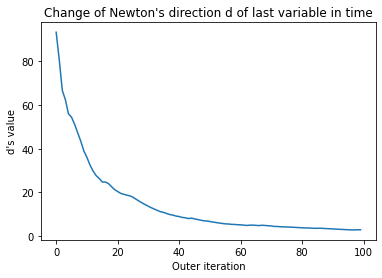

In [210]:
ax = sns.lineplot(x = inn_it[0:100], y = ds2)
ax.set_title("Change of Newton's direction d of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("d's value")





Text(0, 0.5, "D''(0) value")

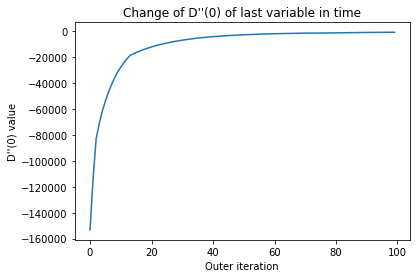

In [211]:
ax = sns.lineplot(x = inn_it[0:100], y = dprim0s2)
ax.set_title("Change of D''(0) of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("D''(0) value")





Text(0, 0.5, "Weights' sum")

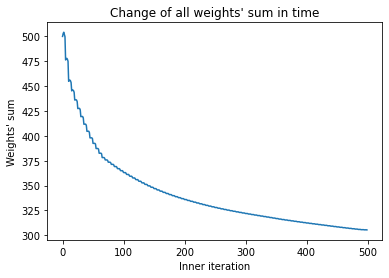

In [212]:
ax = sns.lineplot(x = inn_it, y = weights_sums)
ax.set_title("Change of all weights' sum in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Weights' sum")





LinearSVC Accuracy ( for comparison): 0.9890909090909091


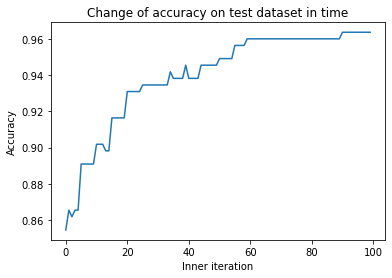

In [213]:
ax = sns.lineplot(x = inn_it[0:100], y = accs_inner[0:100])
ax.set_title("Change of accuracy on test dataset in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Accuracy")

print("LinearSVC Accuracy ( for comparison): " + str(svc_acc))





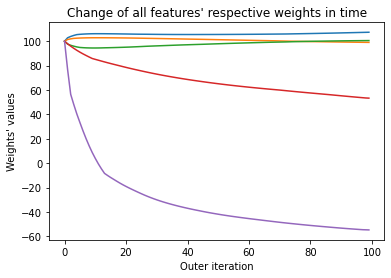

In [215]:
ax = sns.lineplot(x = inn_it[0:100], y = first_weights[0:100])
ax.set_title("Change of all features' respective weights in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("Weights' values")


for i in range(1, len(almighty_all_weights)):
    sns.lineplot(x = inn_it[0:100], y = almighty_all_weights[i][0:100])

## Checking convergence and performance for 2000 iterations

In [224]:
# svc from library
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = "l1", loss = "squared_hinge", max_iter = 2000, C = 5, dual = False) # last 2 params - same as in our algorithm

t0 = time()
svc.fit(X_train,Y_train)
t1 = time()

print("Time of LinearSVC algorithm per iteration: " + str((t1-t0)/100  ) + " seconds")

svc_acc = svc.score(X_test,Y_test)

print("Acc: " + str(svc_acc))

Time of LinearSVC algorithm per iteration: 0.0003458046913146973 seconds
Acc: 0.9927272727272727


In [223]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X_train.shape[1]
n_of_observations = Y_train.shape[0]


# saved variables

# inner
dprim0s = []
dbis0s = []
ds = []
weights_sums = []
accs_inner = []
almighty_all_weights = []

for i in range(n_of_features):
    almighty_all_weights.append(list())

#outer
dprim0s2 = []
dbis0s2 = []
ds2 = []
first_weights = []
outer_iteration_times = []
accs = []



# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
weights = np.ones((n_of_features)) * 100

# hyperparameters
beta = 0.5
sigma = 0.01
C = 5

# outer iterations:
for k in range(2000):
    # inner iterations shuld be as many as the number of features
    
    t0 = time()
    
    
    first_weights.append(weights[0])
    for i in range(n_of_features):
        almighty_all_weights[i].append(weights[i])
        
#         if(i%100==0):
#           print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X_train[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y_train[shuffle] #np.array(Y.iloc[shuffle])
        X_ = X_train[shuffle,:]
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        #----- calculating D'  for z = 0 , in the article: equation (9)
        for j in range(n_of_observations): 
            #----- b_j defined in thr article, part of D' calculations
            b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0: #----- indicator defined in the article
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)

        #D_prim_0 += weights[0,i]
        #D_prim_0 += weights[i]


        #----- calculating D''  for z = 0 , in the article: equation (10)
        D_bis_0 = 1 + 2*C*sum_of_squares_of_column

        #-----  equation (13) in the article
        d = -D_prim_0/D_bis_0 
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            

        ds.append(d)
        dprim0s.append(D_prim_0)
        dbis0s.append(D_bis_0)
        weights_sums.append(weights.sum())
        
        
        acc = 0.0
        for l in range(Y_test.shape[0]):
          if np.dot(weights,X_test[l,:])*Y_test[l] < 0:
            acc += 1
        accs_inner.append(acc/Y_test.shape[0])
        
        
        
        
        
        # update weights
        weights[i] -= lambd*d
        
    ds2.append(d)
    dprim0s2.append(D_prim_0)
    dbis0s2.append(D_bis_0)
    outer_iteration_times.append(time() - t0)
        
        
    
    if k % 100 == 0:
#     if True:
        print("outer iteration - ", k)
        acc = 0.0
        for i in range(Y_test.shape[0]):
          if np.dot(weights,X_test[i,:])*Y_test[i] < 0:
            acc += 1
        print("Accuracy ",acc/Y_test.shape[0])
        print("Weights sum: ",weights.sum())
        print("\n")
        accs.append(acc/Y_test.shape[0])



outer iteration -  0
Accuracy  0.8909090909090909
Weights sum:  476.3312051209003


outer iteration -  100
Accuracy  0.9745454545454545
Weights sum:  305.10974674911563


outer iteration -  200
Accuracy  0.9818181818181818
Weights sum:  288.30399306734574


outer iteration -  300
Accuracy  0.9818181818181818
Weights sum:  276.8406959458678


outer iteration -  400
Accuracy  0.9818181818181818
Weights sum:  267.7125608006264


outer iteration -  500
Accuracy  0.9818181818181818
Weights sum:  262.1645182248898


outer iteration -  600
Accuracy  0.9818181818181818
Weights sum:  258.0893882162822


outer iteration -  700
Accuracy  0.9818181818181818
Weights sum:  255.09144060970186


outer iteration -  800
Accuracy  0.9818181818181818
Weights sum:  252.82199727990138


outer iteration -  900
Accuracy  0.9818181818181818
Weights sum:  251.06031204873386


outer iteration -  1000
Accuracy  0.9818181818181818
Weights sum:  249.65903753746875


outer iteration -  1100
Accuracy  0.9818181818181

KeyboardInterrupt: 

In [225]:
print("MAX ACCURACY ON TEST DATASET: " + str(np.max(accs_inner)))



MAX ACCURACY ON TEST DATASET: 0.9854545454545455


In [228]:
print("AVERAGE TIME PER OUTER ITERATION: " + str(round(np.mean(outer_iteration_times), 5)) + " seconds")

inn_it = np.arange(0, len(ds))

AVERAGE TIME PER OUTER ITERATION: 0.07366 seconds


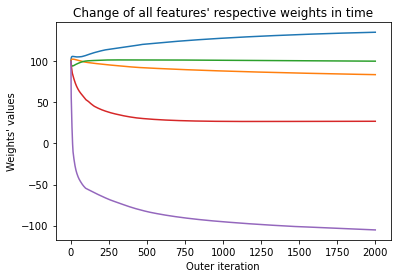

In [229]:
ax = sns.lineplot(x = inn_it[0:2000], y = first_weights[0:2000])
ax.set_title("Change of all features' respective weights in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("Weights' values")


for i in range(1, len(almighty_all_weights)):
    sns.lineplot(x = inn_it[0:2000], y = almighty_all_weights[i][0:2000])

# 2. Wisconsin breast cancer

In [147]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

data = pd.read_csv("data/breast-cancer-wisconsin.data", header = None).iloc[:,1:11]


data.head()

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [153]:
X = data.iloc[:,0:9]
X.head()

Y = data.iloc[:, 9]

supermapping = {2: -1, 4: 1}

Y = Y.map(supermapping)

In [154]:
X.dtypes
X = X.drop(6, axis = 1)

In [155]:
X = np.array(X)
Y = np.array(Y)

for i in range(X.shape[1]):
  mean = X[:,i].mean()
  std = X[:,i].std()
  if std == 0: #If column of zeros
    std = 1
    print("Std is Zero")
    print(i)
  X[:,i] = (X[:,i] - mean)/std

# free term
X = np.concatenate([X, np.ones(shape = (X.shape[0], 1))], axis=1)

In [156]:
X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 2., 2., ..., 2., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [158]:
# train test split 80/20%


X_train, X_test,Y_train, Y_test = train_test_split(X,Y, random_state=44, train_size= 0.8)




In [159]:
# svc from library
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = "l1", loss = "squared_hinge", max_iter = 100, C = 5, dual = False) # last 2 params - same as in our algorithm

t0 = time()
svc.fit(X_train,Y_train)
t1 = time()

print("Time of LinearSVC algorithm per iteration: " + str((t1-t0)/100  ) + " seconds")

svc_acc = svc.score(X_test,Y_test)

print("Acc: " + str(svc_acc))

Time of LinearSVC algorithm per iteration: 3.700733184814453e-05 seconds
Acc: 0.9285714285714286


In [160]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X_train.shape[1]
n_of_observations = Y_train.shape[0]


# saved variables

# inner
dprim0s = []
dbis0s = []
ds = []
weights_sums = []
accs_inner = []
almighty_all_weights = []

for i in range(n_of_features):
    almighty_all_weights.append(list())

#outer
dprim0s2 = []
dbis0s2 = []
ds2 = []
first_weights = []
outer_iteration_times = []
accs = []



# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
weights = np.ones((n_of_features)) * 100

# hyperparameters
beta = 0.5
sigma = 0.01
C = 5

# outer iterations:
for k in range(100):
    # inner iterations shuld be as many as the number of features
    
    t0 = time()
    
    
    first_weights.append(weights[0])
    for i in range(n_of_features):
        almighty_all_weights[i].append(weights[i])
        
#         if(i%100==0):
#           print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X_train[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y_train[shuffle] #np.array(Y.iloc[shuffle])
        X_ = X_train[shuffle,:]
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        #----- calculating D'  for z = 0 , in the article: equation (9)
        for j in range(n_of_observations): 
            #----- b_j defined in thr article, part of D' calculations
            b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0: #----- indicator defined in the article
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)

        #D_prim_0 += weights[0,i]
        #D_prim_0 += weights[i]


        #----- calculating D''  for z = 0 , in the article: equation (10)
        D_bis_0 = 1 + 2*C*sum_of_squares_of_column

        #-----  equation (13) in the article
        d = -D_prim_0/D_bis_0 
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            

        ds.append(d)
        dprim0s.append(D_prim_0)
        dbis0s.append(D_bis_0)
        weights_sums.append(weights.sum())
        
        
        acc = 0.0
        for l in range(Y_test.shape[0]):
          if np.dot(weights,X_test[l,:])*Y_test[l] < 0:
            acc += 1
        accs_inner.append(acc/Y_test.shape[0])
        
        
        
        
        
        # update weights
        weights[i] -= lambd*d
        
    ds2.append(d)
    dprim0s2.append(D_prim_0)
    dbis0s2.append(D_bis_0)
    outer_iteration_times.append(time() - t0)
        
        
    
    if k % 10 == 0:
#     if True:
        print("outer iteration - ", k)
        acc = 0.0
        for i in range(Y_test.shape[0]):
          if np.dot(weights,X_test[i,:])*Y_test[i] < 0:
            acc += 1
        print("Accuracy ",acc/Y_test.shape[0])
        print("Weights sum: ",weights.sum())
        print("\n")
        accs.append(acc/Y_test.shape[0])



outer iteration -  0
Accuracy  0.9071428571428571
Weights sum:  -575.2901980322606


outer iteration -  10
Accuracy  0.9214285714285714
Weights sum:  -683.6461901090802


outer iteration -  20
Accuracy  0.9285714285714286
Weights sum:  -617.8290557222489


outer iteration -  30
Accuracy  0.9357142857142857
Weights sum:  -557.4689736404565


outer iteration -  40
Accuracy  0.9285714285714286
Weights sum:  -509.0337094363647


outer iteration -  50
Accuracy  0.9285714285714286
Weights sum:  -467.0331310600284


outer iteration -  60
Accuracy  0.9285714285714286
Weights sum:  -428.9508212139556


outer iteration -  70
Accuracy  0.9285714285714286
Weights sum:  -395.7686606426171


outer iteration -  80
Accuracy  0.9285714285714286
Weights sum:  -369.34925412325896


outer iteration -  90
Accuracy  0.9285714285714286
Weights sum:  -345.5709138613934




In [245]:
# # algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


# n_of_features = X.shape[1]
# n_of_observations = Y.shape[0]


# # initial weights

# #weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
# weights = np.ones((n_of_features)) * -100

# # hyperparameters
# beta = 0.5
# sigma = 0.01
# C = 5

# # outer iterations:
# for k in range(1000):
#     # inner iterations shuld be as many as the number of features
#     for i in range(n_of_features):
# #         if(i%100==0):
# #           print("feature " , i)
#         shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
#         col = X[:,i] #index2Col(X, i)
        
#         # reorder randomly column of X and target (Y):
#         col_ = col[shuffle]
#         Y_ = Y[shuffle] #np.array(Y.iloc[shuffle])
#         X_ = X[shuffle,:]
        
#         # solving the sub-problem and update weight_i
        
#         ### calculating Newton direction d
        
#         D_prim_0 = 0
        
#         sum_of_squares_of_column = 0
        
#         #----- calculating D'  for z = 0 , in the article: equation (9)
#         for j in range(n_of_observations): 
#             #----- b_j defined in thr article, part of D' calculations
#             b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
#             #print(float(np.dot(weights,index2Row(df,j))),b_j)
#             if b_j > 0.0: #----- indicator defined in the article
#                 D_prim_0 += Y_[j]*col_[j]*b_j
#                 sum_of_squares_of_column += col_[j]**2
            
            
#         D_prim_0 *= (-2*C)

#         #D_prim_0 += weights[0,i]
#         #D_prim_0 += weights[i]


#         #----- calculating D''  for z = 0 , in the article: equation (10)
#         D_bis_0 = 1 + 2*C*sum_of_squares_of_column

#         #-----  equation (13) in the article
#         d = -D_prim_0/D_bis_0 
#         ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
#         # we do this to ensure sufficient convergence condition & to make calculations quicker
#         # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
#         H_i = 1 + 2*C*np.dot(col_.T,col_)
#         lambda_ = D_bis_0 /((H_i/2)+sigma)
        
#         lambd = 1
#         while lambd > lambda_:
#             lambd *= beta
            
#         # update weights
#         weights[i] -= lambd*d
#     if k % 100 == 0:
# #     if True:
#         print("outer iteration - ", k)
#         acc = 0.0
#         for i in range(n_of_observations):
#           if np.dot(weights,X[i,:])*Y[i] < 0:
#             acc += 1
#         print("Accuracy ",acc/n_of_observations)
#         print("Weights sum: ",weights.sum())
#         print("\n")



outer iteration -  0
Accuracy  0.6738197424892703
Weights sum:  -15.533713864091453


outer iteration -  100
Accuracy  0.9413447782546495
Weights sum:  106.34219318891958


outer iteration -  200
Accuracy  0.949928469241774
Weights sum:  99.93456249351736


outer iteration -  300
Accuracy  0.9513590844062947
Weights sum:  87.76409865849202


outer iteration -  400
Accuracy  0.9513590844062947
Weights sum:  76.61881618127036


outer iteration -  500
Accuracy  0.9513590844062947
Weights sum:  67.37694967893914


outer iteration -  600
Accuracy  0.949928469241774
Weights sum:  59.10135826029666


outer iteration -  700
Accuracy  0.9484978540772532
Weights sum:  51.969878545492286


outer iteration -  800
Accuracy  0.9470672389127325
Weights sum:  45.933842785060115


outer iteration -  900
Accuracy  0.9484978540772532
Weights sum:  40.48627866059195




In [161]:
print("MAX ACCURACY ON TEST DATASET: " + str(np.max(accs_inner)))

MAX ACCURACY ON TEST DATASET: 0.9428571428571428


In [162]:
print("AVERAGE TIME PER OUTER ITERATION: " + str(round(np.mean(outer_iteration_times), 5)) + " seconds")

inn_it = np.arange(0, len(ds))

AVERAGE TIME PER OUTER ITERATION: 0.08056 seconds


Text(0, 0.5, "d's value")

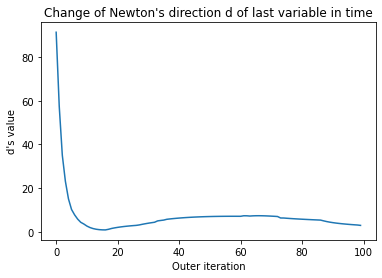

In [168]:
ax = sns.lineplot(x = inn_it[0:100], y = ds2)
ax.set_title("Change of Newton's direction d of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("d's value")



Text(0, 0.5, "D''(0) value")

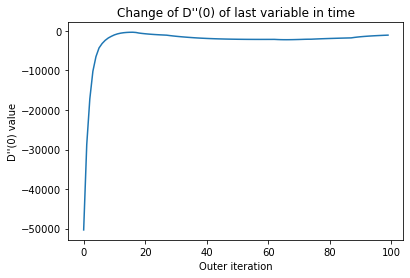

In [167]:
ax = sns.lineplot(x = inn_it[0:100], y = dprim0s2)
ax.set_title("Change of D''(0) of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("D''(0) value")



Text(0, 0.5, "Weights' sum")

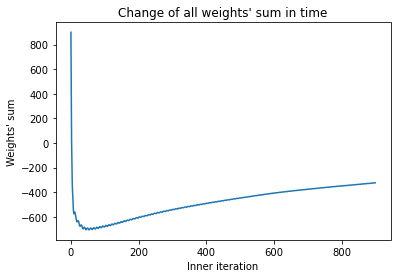

In [172]:
ax = sns.lineplot(x = inn_it, y = weights_sums)
ax.set_title("Change of all weights' sum in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Weights' sum")



LinearSVC Accuracy ( for comparison): 0.9285714285714286


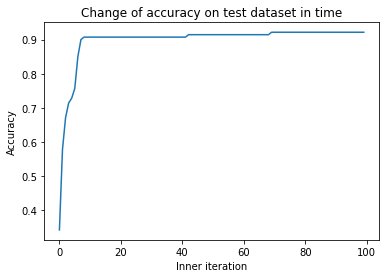

In [175]:
ax = sns.lineplot(x = inn_it[0:100], y = accs_inner[0:100])
ax.set_title("Change of accuracy on test dataset in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Accuracy")

print("LinearSVC Accuracy ( for comparison): " + str(svc_acc))



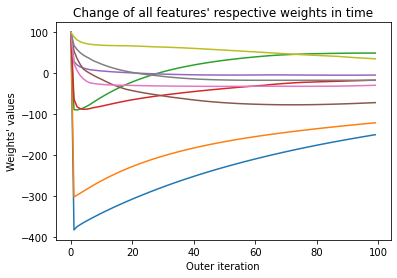

In [181]:
ax = sns.lineplot(x = inn_it[0:100], y = first_weights[0:100])
ax.set_title("Change of all features' respective weights in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("Weights' values")


for i in range(1, len(almighty_all_weights)):
    sns.lineplot(x = inn_it[0:100], y = almighty_all_weights[i][0:100])

# 3. Haberman data

In [6]:
# https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival

data = pd.read_csv("data/haberman.data", header= None)

In [7]:
X = data.iloc[:, 0:3]

Y = data.iloc[:,3]

supermapping = {1: -1, 2: 1}

Y = Y.map(supermapping)

In [5]:
np.unique(Y)

array([-1,  1], dtype=int64)

In [6]:
X.std()

0    10.803452
1     3.249405
2     7.189654
dtype: float64

In [8]:
X = np.array(X)
Y = np. array(Y)

In [9]:
for i in range(X.shape[1]):
  mean = X[:,i].mean()
  std = X[:,i].std()
  if std == 0: #If column of zeros
    std = 1
    print("Std is Zero")
    print(i)
  X[:,i] = (X[:,i] - mean)/std

In [10]:
# free term
X = np.concatenate([X, np.ones(shape = (X.shape[0], 1))], axis=1)

In [11]:
# train test split 80/20%


X_train, X_test,Y_train, Y_test = train_test_split(X,Y, random_state=44, train_size= 0.8)




In [12]:
# svc from library
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = "l1", loss = "squared_hinge", max_iter = 100, C = 5, dual = False) # last 2 params - same as in our algorithm

t0 = time()
svc.fit(X_train,Y_train)
t1 = time()

print("Time of LinearSVC algorithm per iteration: " + str((t1-t0)/100  ) + " seconds")

svc_acc = svc.score(X_test,Y_test)

print("Acc: " + str(svc_acc))

Time of LinearSVC algorithm per iteration: 0.0 seconds
Acc: 0.7096774193548387


In [13]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X_train.shape[1]
n_of_observations = Y_train.shape[0]


# saved variables

# inner
dprim0s = []
dbis0s = []
ds = []
weights_sums = []
accs_inner = []
almighty_all_weights = []

for i in range(n_of_features):
    almighty_all_weights.append(list())

#outer
dprim0s2 = []
dbis0s2 = []
ds2 = []
first_weights = []
outer_iteration_times = []
accs = []



# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 1 # initial weights of predictors
weights = np.ones((n_of_features)) * 100

# hyperparameters
beta = 0.5
sigma = 0.01
C = 5

# outer iterations:
for k in range(100):
    # inner iterations shuld be as many as the number of features
    
    t0 = time()
    
    
    first_weights.append(weights[0])
    for i in range(n_of_features):
        almighty_all_weights[i].append(weights[i])
        
#         if(i%100==0):
#           print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X_train[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y_train[shuffle] #np.array(Y.iloc[shuffle])
        X_ = X_train[shuffle,:]
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        #----- calculating D'  for z = 0 , in the article: equation (9)
        for j in range(n_of_observations): 
            #----- b_j defined in thr article, part of D' calculations
            b_j = max(Y_[j]*float(np.dot(weights,X_[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0: #----- indicator defined in the article
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)
        D_prim_0 += np.sign(weights[i]) # L1 regularization

        #D_prim_0 += weights[0,i]
        #D_prim_0 += weights[i]


        #----- calculating D''  for z = 0 , in the article: equation (10)
#         D_bis_0 = 1 + 2*C*sum_of_squares_of_column # L2 regularization
        D_bis_0 = 2*C*sum_of_squares_of_column # L1 reglarization
        #-----  equation (13) in the article
        d = -D_prim_0/D_bis_0 
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        # Theorem 1 ( from article) indicated that lambda_ (14) fulfilling (15) 
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            

        ds.append(d)
        dprim0s.append(D_prim_0)
        dbis0s.append(D_bis_0)
        weights_sums.append(weights.sum())
        
        
        acc = 0.0
        for l in range(Y_test.shape[0]):
          if np.dot(weights,X_test[l,:])*Y_test[l] < 0:
            acc += 1
        accs_inner.append(acc/Y_test.shape[0])
        
        
        
        
        
        # update weights
        weights[i] -= lambd*d
        
    ds2.append(d)
    dprim0s2.append(D_prim_0)
    dbis0s2.append(D_bis_0)
    outer_iteration_times.append(time() - t0)
        
        
    
    if k % 10 == 0:
#     if True:
        print("outer iteration - ", k)
        acc = 0.0
        for i in range(Y_test.shape[0]):
          if np.dot(weights,X_test[i,:])*Y_test[i] < 0:
            acc += 1
        print("Accuracy ",acc/Y_test.shape[0])
        print("Weights sum: ",weights.sum())
        print("\n")
        accs.append(acc/Y_test.shape[0])


outer iteration -  0
Accuracy  0.7419354838709677
Weights sum:  134.84920944461612


outer iteration -  10
Accuracy  0.7258064516129032
Weights sum:  -0.46686446642732227


outer iteration -  20
Accuracy  0.6774193548387096
Weights sum:  -0.13929371667207785


outer iteration -  30
Accuracy  0.6935483870967742
Weights sum:  -0.011981415533101355


outer iteration -  40
Accuracy  0.6935483870967742
Weights sum:  -0.0014360909187469892


outer iteration -  50
Accuracy  0.6935483870967742
Weights sum:  -0.0008898867643792607


outer iteration -  60
Accuracy  0.6935483870967742
Weights sum:  -0.0008584292562724086


outer iteration -  70
Accuracy  0.6935483870967742
Weights sum:  -0.0008566455179715993


outer iteration -  80
Accuracy  0.6935483870967742
Weights sum:  -0.0008565444927456662


outer iteration -  90
Accuracy  0.6935483870967742
Weights sum:  -0.0008565387712846382




In [14]:
print("MAX ACCURACY ON TEST DATASET: " + str(np.max(accs_inner)))

MAX ACCURACY ON TEST DATASET: 0.8064516129032258


In [15]:
print("AVERAGE TIME PER OUTER ITERATION: " + str(round(np.mean(outer_iteration_times), 5)) + " seconds")

AVERAGE TIME PER OUTER ITERATION: 0.0114 seconds


In [16]:
inn_it = np.arange(0, len(ds))

Text(0, 0.5, "d's value")

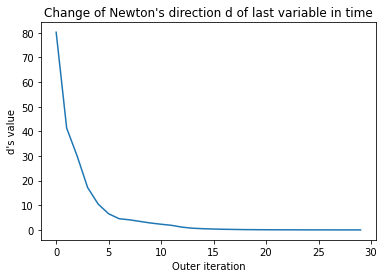

In [17]:
ax = sns.lineplot(x = inn_it[0:30], y = ds2[0:30])
ax.set_title("Change of Newton's direction d of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("d's value")

Text(0, 0.5, "D''(0) value")

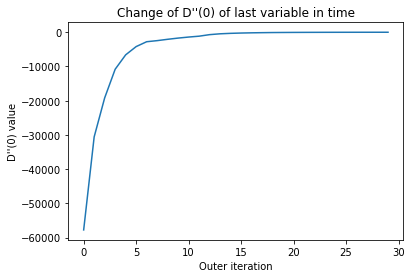

In [18]:
ax = sns.lineplot(x = inn_it[0:30], y = dprim0s2[0:30])
ax.set_title("Change of D''(0) of last variable in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("D''(0) value")

Text(0, 0.5, "Weights' sum")

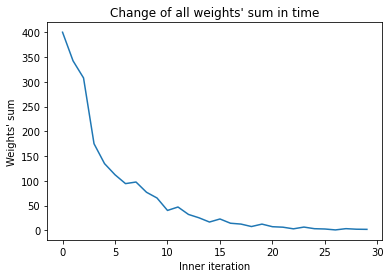

In [19]:
ax = sns.lineplot(x = inn_it[0:30], y = weights_sums[0:30])
ax.set_title("Change of all weights' sum in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Weights' sum")

LinearSVC Accuracy ( for comparison): 0.7096774193548387


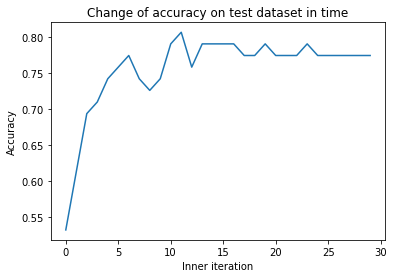

In [20]:
ax = sns.lineplot(x = inn_it[0:30], y = accs_inner[0:30])
ax.set_title("Change of accuracy on test dataset in time")
ax.set_xlabel("Inner iteration")
ax.set_ylabel("Accuracy")

print("LinearSVC Accuracy ( for comparison): " + str(svc_acc))

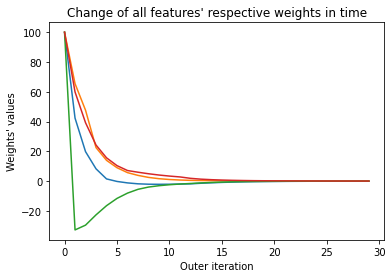

In [21]:
ax = sns.lineplot(x = inn_it[0:30], y = first_weights[0:30])
ax.set_title("Change of all features' respective weights in time")
ax.set_xlabel("Outer iteration")
ax.set_ylabel("Weights' values")


for i in range(1, len(almighty_all_weights)):
    sns.lineplot(x = inn_it[0:30], y = almighty_all_weights[i][0:30])

# Conclusions

Above results showed that implemented algorithm converges for all given datasets, with weights initialization of 100.

Respective weights tend to 0 with each outer iteration -- it is due to used regularization term which favorises small absolute value weights over big-value weights.

Accuracies obtained on test datasets in comparison with LinearSVC results are as follows:


* artificial data: This implementation 0.965, **LinearSVC 0.971**
* smoking data: This implementation 0.685, **LinearSVC 0.744**
* banknote authentication data: This implementation 0.978, **LinearSVC 0.989**
* wisconsin heart data: **This implementation 0.943**, Linear SVC 0.929
* heberman data: **This implementation 0.806**, LinarSVC 0.710

Bolded results are higher results. As we can see for 2 out of 5 datasets, this project's SVC implementation performed better than LinearSVC. One could deduce that this implementation is competetive with LinearSVC's implementation as far as Accuracy is concerned. Nevertheless, as we can see from outer iteration average time -- it is clear that LinearSVC is better optimized for data in tabular format.



# Other - real-sim from the article, Full loaded data

In [ ]:
X = np.array(X)
Y = np.array(target_df)

In [ ]:
X.shape

(72309, 20958)

In [ ]:
for i in range(20958-1):
  mean = X[:,i].mean()
  std = X[:,i].std()
  if std == 0: #If column of zeros
    std = 1
    print("Std is Zero, ID:", i)
    
  X[:,i] = (X[:,i] - mean)/std

Std is Zero
0
Std is Zero
9646
Std is Zero
10252
Std is Zero
10597
Std is Zero
10618
Std is Zero
11565
Std is Zero
12211
Std is Zero
12241
Std is Zero
12263
Std is Zero
12279
Std is Zero
12948
Std is Zero
14052
Std is Zero
14617
Std is Zero
15313


IndexError: ignored

In [ ]:
# algorithm described in https://jmlr.org/papers/volume9/chang08a/chang08a.pdf


n_of_features = X.shape[1]
n_of_observations = Y.shape[0]


# initial weights

#weights = np.ones(shape = (1,n_of_features) ) * 0.01 # initial weights of predictors
weights = np.ones((n_of_features)) * 0.01

# hyperparameters
beta = 0.5
sigma = 0.01
C = 0.01

# outer iterations:
for k in range(4):
    # inner iterations shuld be as many as the number of features
    for i in range(n_of_features):
        startTime = time.time()
      
        if(i%100==0):
          print("feature " , i)
        shuffle = np.random.choice(n_of_observations, n_of_observations, replace = False) # shuffling recommended by authors
        col = X[:,i] #index2Col(X, i)
        
        # reorder randomly column of X and target (Y):
        col_ = col[shuffle]
        Y_ = Y[shuffle] #np.array(Y.iloc[shuffle])
        
        
        # solving the sub-problem and update weight_i
        
        ### calculating Newton direction d
        
        D_prim_0 = 0
        
        sum_of_squares_of_column = 0
        
        for j in range(n_of_observations): 

            b_j = max(Y_[j]*float(np.dot(weights,X[j,:])),0)
            #print(float(np.dot(weights,index2Row(df,j))),b_j)
            if b_j > 0.0:
                D_prim_0 += Y_[j]*col_[j]*b_j
                sum_of_squares_of_column += col_[j]**2
            
            
        D_prim_0 *= (-2*C)
        #D_prim_0 += weights[0,i]
        D_prim_0 += weights[i]
                
        D_bis_0 = 1 + 2*C*sum_of_squares_of_column
        d = -D_prim_0/D_bis_0
        
        ### compute lambda = max{1, beta, beta^2, beta^3, ...}
        
        # we do this to ensure sufficient convergence condition & to make calculations quicker
        
        H_i = 1 + 2*C*np.dot(col_.T,col_)
        lambda_ = D_bis_0 /((H_i/2)+sigma)
        
        lambd = 1
        while lambd > lambda_:
            lambd *= beta
            
        # update weights
        weights[i] += lambd*d
        executionTime = (time.time() - startTime)
        print('Execution time in seconds: ' + str(executionTime))
    print("outer iteration - ", k)
    acc = 0.0
    for i in range(d_d):
      if np.dot(weights,X[i,:])*Y[i] > 0:
        acc += 1
    print(acc/d_d)





feature  0
Execution time in seconds: 14.164132833480835
Execution time in seconds: 10.2814302444458
Execution time in seconds: 10.202035665512085
Execution time in seconds: 10.176557779312134
Execution time in seconds: 10.259861707687378


KeyboardInterrupt: ignored